# Pulse Shape Discrimination using Support Vector Machines (SVM)
## Brief Background and Introduction
Pulse Shape Discrimination is a problem where one tries to distinguish pulses based on a measured signal. In this case, we are trying to distinguish between neutron and gamma rays from a signal that contains both of them. If this were to be implemented into a machine learning problem, the optimal approach would be to use pure neutron rays and pure gamma rays as a training set. However, as far as my knowledge goes, it is not possible to obtain these pure signals. Therefore, we rely on a theoretical assumption that can be used to identify the neutron and gamma rays. This assumption has a threshold in which the higher the threshold, the more distinguishable the two rays are. Therefore we will use this assumption with a high threshold as our training set, and the same assumption with a lower threshold as our validation set.

Now we have a classification problem involving just 2 classes, neutron and gamma rays. An approach would be to use a support vector machine that can separate these 2 classes using a hyperplane. The hyperplane parameters are learned throughout the training process.

## Downloading the data
The data is a text file with each line consisting of a pulse that has 240 elements. There are exactly 6 pieces of data, 3 of which are neutron pulses and the other 3 are gamma pulses. They are labelled with respect to the type of pulse and the certainty of the pulse. For example, "forML_gamma_SUPERTIGHT.txt" means that this data contains gamma pulses which were obtained using a high threshold. The labels "SUPERTIGHT", "TIGHT" and "LOOSE correspond to high, medium and low thresholds respectively.

You can download the necessary data in a shared Dropbox link: https://www.dropbox.com/sh/sklqbrd7gvq6azz/AABCExrGTyESctHbs1eQO4m6a?dl=1.
<br/>Put these data in the same working directory as this notebook. There is a code below you can run to obtain it directly. Just click the "Download Pulse Data" button to download.

## Additional Notes
I am going to be using ipywidgets to make this notebook more interactive

In [1]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

And disable autoscrolling for better output observation

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
button = widgets.Button(
    description='Download Pulse Data',
)
display(button)
@button.on_click

def dl_data(*args):
    print("Importing necessary modules for downloading and extracting data...")
    import requests
    import zipfile
    import io

    r = requests.get("https://www.dropbox.com/sh/sklqbrd7gvq6azz/AABCExrGTyESctHbs1eQO4m6a?dl=1", stream=True)
    if r.status_code == requests.codes.ok:
        z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Extracting data into current working directory...")
    z.extractall()
    print("Data downloaded and extracted to current working directory!")

Button(description='Download Pulse Data', style=ButtonStyle())

Lets double check that the data files are indeed in the current working directory

In [4]:
ls

 Volume in drive C is OS
 Volume Serial Number is E813-1724

 Directory of C:\Users\alex2\Dropbox\PSD\fromAlex

27/11/2018  11:29 PM    <DIR>          .
27/11/2018  11:29 PM    <DIR>          ..
27/11/2018  11:09 PM    <DIR>          .ipynb_checkpoints
26/11/2018  02:49 AM    <DIR>          __pycache__
20/11/2018  10:33 PM    <DIR>          data
27/11/2018  03:34 AM             4,453 data_processing.py
27/11/2018  11:05 PM        51,141,242 forML_gamma_LOOSE.txt
27/11/2018  11:05 PM        12,091,938 forML_gamma_SUPERTIGHT.txt
27/11/2018  11:05 PM        33,065,150 forML_gamma_TIGHT.txt
27/11/2018  11:05 PM        29,551,241 forML_neutron_LOOSE.txt
27/11/2018  11:05 PM         9,821,910 forML_neutron_SUPERTIGHT.txt
27/11/2018  11:05 PM        18,758,073 forML_neutron_TIGHT.txt
24/11/2018  10:23 PM             1,326 LinearSVM Details.txt
27/11/2018  03:45 AM             6,919 main.py
24/11/2018  09:26 PM               326 model.py
24/11/2018  10:20 PM             6,647 nndetails.py
27/1

Importing all necessary modules

In [5]:
import argparse
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

Details widgets

In [6]:
style = {'description_width': '60%'}
w_tnum = widgets.IntText(500, description='Training Dataset Size', style=style)
w_tbs = widgets.IntText(10, description='Training Batch Size', style=style)
w_vnum = widgets.IntText(100, description='Validation Dataset Size', style=style)
w_vbs = widgets.IntText(1, description='Validation Batch Size', style=style)
w_epoch = widgets.IntText(10, description='No. of Epochs', style=style)
w_lr = widgets.FloatText(0.01, description='Learning Rate', style=style)
w_c = widgets.FloatText(0.01, description='Regularization', style=style)

Data Processing functions

In [7]:
class PSD_Dataset(Dataset):
    """ A class to convert the input data into torch tensors
        and store them in a Dataset object so that it
        can be read later by torch's Dataloader function.
    """

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['pulses'])

    def __getitem__(self, index):
        pulses = torch.FloatTensor(self.data['pulses'][index])
        classes = torch.tensor(self.data['class'][index])
        dataset = {'pulses': pulses, 'class': classes}

        return dataset


def read_data(filename, limit):
    """ In the data .txt file each line is a pulse containing 240 elements.
        This function reads the data and stores the pulses into a list then into a dictionary
        Then by classifying neutrons into '1' and gammas into '-1',
        the pulses are 'labelled' according to where they came from by putting another key called 'class'.

        The 'limit' is the amount of pulses to be read.
    """

    with open(filename, 'r') as file:
        data_list = [list(map(int, lines.split())) for i, lines in enumerate(file.readlines()) if len(lines.split()) == 240 and i < limit]
        # The above single line is equivalent to the following:
        # data_list = []
        # for i, lines in enumerate(file.readlines()):
        #     if len(lines.split()) == 240 and i < limit:
        #         data_list.append(list(map(int, lines.split)))

        # Classification
        if 'neutron' in filename:
            data_dict = {'pulses': data_list, 'class': np.ones(len(data_list)).tolist()}
        elif 'gamma' in filename:
            data_dict = {'pulses': data_list, 'class': (-1 * np.ones(len(data_list))).tolist()}

    return data_dict


def Normalization(data):
    """ Normalizes the pulse data of size N-by-240.
        Therefore getting the mean and standard deviation by rows (axis=1).
        Normalization: (pulse   -  mean) / standard deviation
                 Size: ((N,240) - (N,1)) / (N,1)
    """

    pulse = np.asarray(data)
    pulse_mean = np.mean(pulse, axis=1)[:, None]
    pulse_std = np.std(pulse, axis=1)[:, None]
    data_normalized = ((pulse - pulse_mean) / pulse_std).tolist()
    return data_normalized


def get_data(*args):
    """ Gets the data in .txt, reads it, normalizes the pulses, stores it into a dictionary,
        gets converted into torch tensors and finally stored in a Dataloader
    """

    # Gamma pulses
    gamma_loose = 'forML_gamma_LOOSE.txt'
    gamma_tight = 'forML_gamma_TIGHT.txt'
    gamma_supertight = 'forML_gamma_SUPERTIGHT.txt'

    # Neutron pulses
    neutron_loose = 'forML_neutron_LOOSE.txt'
    neutron_tight = 'forML_neutron_TIGHT.txt'
    neutron_supertight = 'forML_neutron_SUPERTIGHT.txt'

    # Training Dataset
    training_pulses_fname = [gamma_supertight, neutron_supertight]
    print("Training Database: {}".format(training_pulses_fname))
    training_pulses = []
    training_class = []
    for fname in training_pulses_fname:
        training_pulses += read_data(fname, int(w_tnum.value / len(training_pulses_fname)))['pulses']
        training_class += read_data(fname, int(w_tnum.value / len(training_pulses_fname)))['class']
        training_data = {'pulses': Normalization(training_pulses), 'class': training_class}

    # Validation Dataset
    validation_pulses_fname = [gamma_loose, gamma_tight, neutron_loose, neutron_tight]
    print("Validation Database: {}".format(validation_pulses_fname))
    validation_pulses = []
    validation_class = []
    for fname in validation_pulses_fname:
        validation_pulses += read_data(fname, int(w_vnum.value / len(validation_pulses_fname)))['pulses']
        validation_class += read_data(fname, int(w_vnum.value / len(validation_pulses_fname)))['class']
        validation_data = {'pulses': Normalization(validation_pulses), 'class': validation_class}

    # Datasets and Loaders ready for training
    train_dataset = PSD_Dataset(training_data)
    validation_dataset = PSD_Dataset(validation_data)
    train_loader = DataLoader(dataset=train_dataset, batch_size=w_tbs.value, shuffle=True)
    validation_loader = DataLoader(dataset=validation_dataset, batch_size=w_vbs.value, shuffle=False)

    return train_loader, validation_loader

Training and Validation Functions

In [8]:
def train(model, data_loader, *args):
    """ Function for training the data. """

    optimizer = optim.SGD(model.parameters(), lr=w_lr.value)
    model.train()
    print("CNN Model: {}".format(model.__class__.__name__))
    print("Optimizer: {}".format(optimizer.__class__.__name__))

    for epoch in range(w_epoch.value):
        sum_loss = 0
        for i, data in enumerate(data_loader):
            input_pulses = data['pulses']
            classes = data['class']

            # If CUDA is available
            if torch.cuda.is_available():
                input_pulses = input_pulses.cuda()
                classes = data['class'].cuda()

            optimizer.zero_grad()
            output = model(input_pulses)

            # Loss Function:
            loss = torch.mean(torch.clamp(1 - output.t() * classes, min=0))  # hinge loss
            loss += w_c.value * torch.mean(model.fc.weight ** 2)  # l2 penalty
            loss.backward()

            optimizer.step()
            sum_loss += loss.data.cpu().numpy()

        print("Epoch [{}/{}], Loss: {}".format(epoch + 1, w_epoch.value, sum_loss / w_tnum.value))


def validation(model, data_loader, *args):
    """ Function for validating the data. """

    model.eval()
    correct_predictions = w_vnum.value
    actual_predictions_clamped = []

    for i, data in enumerate(data_loader):

        input_pulses = data['pulses']
        classes = data['class']

        # If CUDA is available
        if torch.cuda.is_available():
            input_pulses = input_pulses.cuda()
            classes = data['class'].cuda()

        output = model(input_pulses)

        # Comparing output data and class
        output_data = output.data.cpu().numpy()[0][0]
        classes_data = classes.data.cpu().numpy()[0]

        output_data_class = np.sign(output_data)
        if output_data_class != classes_data:
            correct_predictions -= 1

        confidence = 1
        if output_data > -1 and output_data < 1:
            confidence = np.absolute(output_data)

        # Restricting predictions between -1 and 1 for plotting
        actual_predictions_clamped.append(np.clip(output_data, -1, 1))

        print("pulse:{:>4}| class:{:>4}| predicted class:{:>4}| actual prediction:{:>+.4f}| confidence:{:>.2%}"
              .format(i + 1, classes_data, output_data_class, output_data, confidence))

    print("\nAccuracy for {} pulses: {:.2%}".format(w_vnum.value, correct_predictions / w_vnum.value))

    return np.asarray(actual_predictions_clamped)

Function for printing details

In [9]:
def print_args(*args):
    """ Printing of argument values for reference. """

    print("Training Dataset Size: {}".format(w_tnum.value))
    print("Training Batch Size: {}".format(w_tbs.value))
    print("Validation Dataset Size: {}".format(w_vnum.value))
    print("Validation Batch Size: {}".format(w_vbs.value))
    print("No. of Epochs: {}".format(w_epoch.value))
    print("Learning Rate: {}".format(w_lr.value))
    print("Regularization: {}".format(w_c.value))

SVM Model Function

In [10]:
class LinearSVM(nn.Module):
    """ Support Vector Machine:
        1 fully connected linear layer: 240 -> 1
    """

    def __init__(self):
        super(LinearSVM, self).__init__()
        self.fc = nn.Linear(240, 1)

    def forward(self, x):
        h = self.fc(x)
        return h

Plotting Function

In [11]:
def plot(confidence_levels):
    """ Plotting of confidence levels to see the distribution
        of pulses that have been classified. Accurate classification
        would result in having two sharp peaks at 1 and -1.
    """

    f, axes = plt.subplots(1, 2, figsize=(15, 9))

    # Histogram
    sns.distplot(confidence_levels, hist=True, kde=False, norm_hist=False,
                 bins=1000, color='darkblue',
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'linewidth': 2, 'bw': 0.25}, ax=axes[0])
    axes[0].set_ylabel("Count")
    axes[0].set_xlabel("Confidence")
    axes[0].set_title("Neutron = 1, Gamma = -1, Histogram Plot")

    # KDE (Kernel Density Estimate)
    sns.distplot(confidence_levels, hist=False, kde=True, norm_hist=False,
                 bins=1000, color='darkblue',
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'linewidth': 2, 'bw': 0.25}, ax=axes[1])
    axes[1].set_ylabel("Density")
    axes[1].set_xlabel("Confidence")
    axes[1].set_title("Neutron = 1, Gamma = -1, KDE Plot")

    plt.show()

Executing Experiment

Button(description='Run Experiment', style=ButtonStyle())

Retrieving data...
Training Database: ['forML_gamma_SUPERTIGHT.txt', 'forML_neutron_SUPERTIGHT.txt']
Validation Database: ['forML_gamma_LOOSE.txt', 'forML_gamma_TIGHT.txt', 'forML_neutron_LOOSE.txt', 'forML_neutron_TIGHT.txt']
Training Dataset Size: 500
Training Batch Size: 10
Validation Dataset Size: 100
Validation Batch Size: 1
No. of Epochs: 10
Learning Rate: 0.01
Regularization: 0.01
Data Loaded Successfully!
Data Processing Time: 6.481 secs

Training...
CNN Model: LinearSVM
Optimizer: SGD
Epoch [1/10], Loss: 0.08866468751430512
Epoch [2/10], Loss: 0.07218686801195144
Epoch [3/10], Loss: 0.06456548026204109
Epoch [4/10], Loss: 0.0573806901872158
Epoch [5/10], Loss: 0.05114176856353879
Epoch [6/10], Loss: 0.048081358298659324
Epoch [7/10], Loss: 0.0435031525939703
Epoch [8/10], Loss: 0.03821995005011559
Epoch [9/10], Loss: 0.03815011638402939
Epoch [10/10], Loss: 0.03480755534768105
End of training
Training Time: 4.709 secs

Validating...
pulse:   1| class:-1.0| predicted class:-1.0

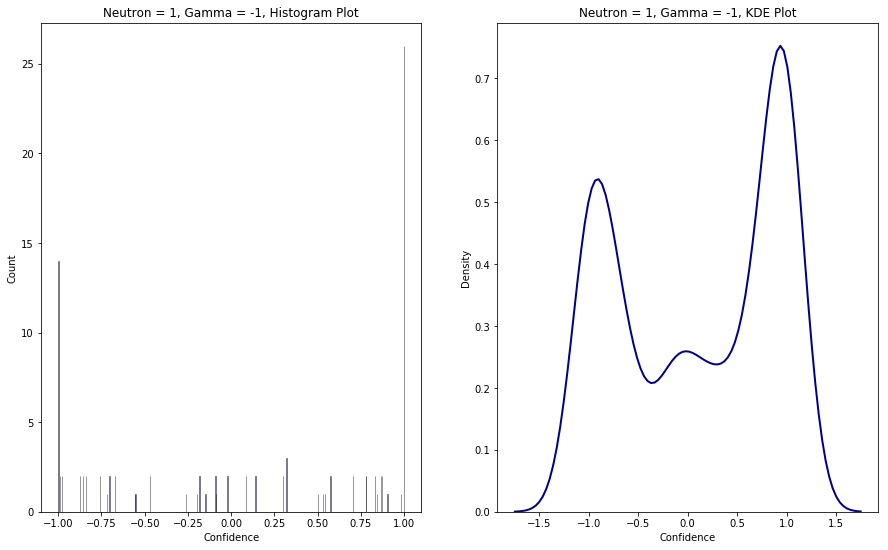

In [12]:
t_box = widgets.HBox([w_tnum, w_tbs])
v_box = widgets.HBox([w_vnum, w_vbs])

display(widgets.VBox([t_box, v_box]))
display(widgets.HBox([w_epoch, w_lr, w_c]))

button = widgets.Button(
    description='Run Experiment',
)
display(button)
@button.on_click
def main(*args):
    """ Main function to be executed. """

    # Data Processing
    start_time = time.time()
    print("Retrieving data...")
    train_loader, validation_loader = get_data()
    get_data_time = time.time()

    # Printing Experiment Details
    print_args()
    print("Data Loaded Successfully!\nData Processing Time: {:.3f} secs\n".format(get_data_time - start_time))

    # Training
    model = LinearSVM()
    if torch.cuda.is_available():
        model.cuda()

    print("Training...")
    train(model, train_loader)
    training_time = time.time()
    print("End of training\nTraining Time: {:.3f} secs\n".format(training_time - get_data_time))

    # Testing
    print("Validating...")
    confidence_levels = validation(model, validation_loader)
    validation_time = time.time()
    print("End of validation\nValidation Time: {:.3f} secs\n".format(validation_time - training_time))
    print("Total Time Elapsed: {:.3f}secs\n".format(time.time() - start_time))
    print("{0:-^31}\n".format("END"))
    
    plot(confidence_levels)